# Figure generation for interpretation key

In [ ]:
# data np https://naturalengland-defra.opendata.arcgis.com/datasets/Defra::national-parks-england/about
# data aonb https://naturalengland-defra.opendata.arcgis.com/datasets/Defra::areas-of-outstanding-natural-beauty-england/about
# data OS GB Grids https://github.com/OrdnanceSurvey/OS-British-National-Grids

In [1]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
from owslib.wms import WebMapService

In [2]:
# import data
np = gpd.read_file("../data/np/National_Parks_(England)___Natural_England.shp")
aonb = gpd.read_file("../data/aonb/Areas_of_Outstanding_Natural_Beauty_(England)___Natural_England.shp")

<Axes: >

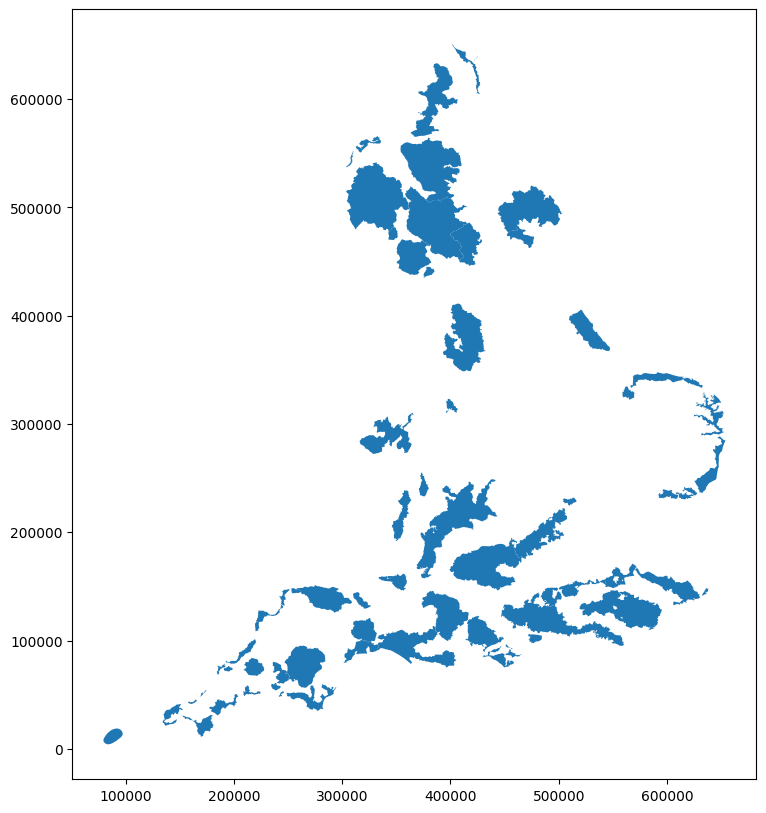

In [3]:
# combine data
pl = pd.concat([np, aonb])
pl.plot(figsize=(10, 10))

In [4]:
os_1k = gpd.read_file("../data/OSGB_Grids/Shapefile/OSGB_Grid_1km.shp")

In [5]:
# Keep each grid cell once even if it intersects multiple PLs
os_1k_pl = gpd.sjoin(
    os_1k, 
    pl[["geometry"]], 
    how="inner", 
    predicate="intersects"
).drop_duplicates(subset=os_1k.columns.tolist(), keep="first")

os_1k_pl = os_1k_pl[os_1k.columns].reset_index(drop=True)

print("1 km cells intersecting PLs:", len(os_1k_pl))

1 km cells intersecting PLs: 37435


In [6]:
os_1k_pl.tail(2)

,PLAN_NO,geometry
37433,TV6097,"POLYGON ((560000.003 97000.003, 560000.003 979..."
37434,TV6098,"POLYGON ((560000.003 97999.997, 560000.003 990..."


## data.md figure

In [12]:
WMS_URL = "https://www.getmapping.com/GmWMS/31583b86-e918-444f-adb6-0aeedfaecb8d/APGB.wmsx"
wms = WebMapService(WMS_URL, version="1.3.0")

print("Service title:", wms.identification.title)
print("Available formats:", wms.getOperationByName("GetMap").formatOptions)

Service title: Getmapping Web Map Server
Available formats: ['image/jpeg', 'image/png']


In [18]:
from owslib.wms import WebMapService

WMS_URL = "https://www.getmapping.com/GmWMS/31583b86-e918-444f-adb6-0aeedfaecb8d/APGB.wmsx"
wms = WebMapService(WMS_URL, version="1.3.0")

lyr = wms["APGB_Latest_UK_125mmIndex"]
print("Queryable:", getattr(lyr, "queryable", None))
print("CRS:", getattr(lyr, "crsOptions", None))



Queryable: 1
CRS: ['EPSG:900913', 'EPSG:3857', 'EPSG:4326', 'EPSG:27700']


In [ ]:
# join
os_1k_pl = os_1k_pl.to_crs(27700).copy()
os_1k_pl["PLAN_NO"] = os_1k_pl["PLAN_NO"].astype(str)

# Join: PLAN_NO == kmreference
os_1k_pl = os_1k_pl.merge(
    wfs_gdf[["kmreference", "date_flown"]],
    left_on="PLAN_NO",
    right_on="kmreference",
    how="left"
).drop(columns=["kmreference"])

os_1k_pl["year"] = os_1k_pl["date_flown"].dt.year

print("Matched tiles with a date:", os_1k_pl["date_flown"].notna().sum(), "of", len(os_1k_pl))


In [ ]:
# aggregate

pl_bng = pl.to_crs(27700)
PL_ID_COL = "name" if "name" in pl_bng.columns else pl_bng.columns[0]

joined = gpd.sjoin(
    os_1k_pl[["PLAN_NO", "date_flown", "year", "geometry"]],
    pl_bng[[PL_ID_COL, "geometry"]],
    how="inner",
    predicate="intersects"
)

pl_latest = (
    joined.groupby(PL_ID_COL)
          .agg(
              latest_date=("date_flown", "max"),
              latest_year=("year", "max"),
              n_tiles=("PLAN_NO", "nunique"),
          )
          .reset_index()
)

pl_out = pl_bng.merge(pl_latest, on=PL_ID_COL, how="left")
pl_latest.sort_values("latest_date", ascending=False).head(10)


In [12]:
import threading, re, os, csv
import pandas as pd
import requests
from tqdm import tqdm
from concurrent.futures import ThreadPoolExecutor, as_completed

WMS_URL = "https://www.getmapping.com/GmWMS/31583b86-e918-444f-adb6-0aeedfaecb8d/APGB.wmsx"
INDEX_LAYER = "APGB_Latest_UK_125mmIndex"
re_dt = re.compile(r"Date Flown:\s*([0-3]?\d/[01]?\d/\d{4})")

thread_local = threading.local()

def get_session():
    if not hasattr(thread_local, "session"):
        thread_local.session = requests.Session()
    return thread_local.session

def fetch_date_for_geom(geom, buf=200, timeout=20):
    s = get_session()
    c = geom.centroid
    E, N = c.x, c.y
    bbox = (E-buf, N-buf, E+buf, N+buf)

    params = {
        "SERVICE":"WMS","VERSION":"1.3.0","REQUEST":"GetFeatureInfo",
        "LAYERS":INDEX_LAYER,"QUERY_LAYERS":INDEX_LAYER,
        "CRS":"EPSG:27700","BBOX":",".join(map(str,bbox)),
        "WIDTH":101,"HEIGHT":101,"I":50,"J":50,
        "INFO_FORMAT":"text/plain","FEATURE_COUNT":1,
        "FORMAT":"image/png","STYLES":"",
    }
    r = s.get(WMS_URL, params=params, timeout=timeout)
    r.raise_for_status()
    m = re_dt.search(r.text)
    return pd.to_datetime(m.group(1), dayfirst=True, errors="coerce") if m else pd.NaT

# --- build the tile set you need (use your existing os_1k_pl) ---
os_1k_pl = os_1k_pl.to_crs(27700).copy()
os_1k_pl["PLAN_NO"] = os_1k_pl["PLAN_NO"].astype(str)

# --- cache as CSV (fast append, resumable) ---
cache_csv = "../data/apgb_latest_125mm_tile_dates.csv"
done = set()
if os.path.exists(cache_csv):
    done_df = pd.read_csv(cache_csv)
    done = set(done_df["PLAN_NO"].astype(str))
    print("Already cached:", len(done))

todo = os_1k_pl.loc[~os_1k_pl["PLAN_NO"].isin(done), ["PLAN_NO","geometry"]]
print("To query:", len(todo))

def append_rows(rows):
    file_exists = os.path.exists(cache_csv)
    with open(cache_csv, "a", newline="") as f:
        w = csv.DictWriter(f, fieldnames=["PLAN_NO","date_flown"])
        if not file_exists:
            w.writeheader()
        w.writerows(rows)

max_workers = 32   # try 32; if you see errors, drop to 16
flush_every = 1000
buffer = []

def worker(plan, geom):
    return plan, fetch_date_for_geom(geom)

with ThreadPoolExecutor(max_workers=max_workers) as ex:
    futures = {ex.submit(worker, r.PLAN_NO, r.geometry): r.PLAN_NO for r in todo.itertuples(index=False)}
    for fut in tqdm(as_completed(futures), total=len(futures)):
        plan = futures[fut]
        try:
            plan, dt = fut.result()
        except Exception:
            dt = pd.NaT
        buffer.append({"PLAN_NO": plan, "date_flown": dt})

        if len(buffer) >= flush_every:
            append_rows(buffer)
            buffer = []

if buffer:
    append_rows(buffer)

print("Cache updated:", cache_csv)


To query: 37435


100%|██████████| 37435/37435 [32:03<00:00, 19.46it/s]  

Cache updated: ../data/apgb_latest_125mm_tile_dates.csv


In [13]:
dates = pd.read_csv(cache_csv)
dates["PLAN_NO"] = dates["PLAN_NO"].astype(str)
dates["date_flown"] = pd.to_datetime(dates["date_flown"], errors="coerce")

os_1k_pl = os_1k_pl.merge(dates, on="PLAN_NO", how="left")
os_1k_pl["year"] = os_1k_pl["date_flown"].dt.year


In [14]:
os_1k_pl.head(2)

,PLAN_NO,geometry,date_flown,year
0,NT6906,"POLYGON ((368999.997 606000.004, 368999.997 60...",2023-06-02,2023.0
1,NT7005,"POLYGON ((369999.999 605000, 369999.999 606000...",2023-06-02,2023.0


In [15]:
print("Tiles:", len(os_1k_pl))
print("Tiles with date:", os_1k_pl["date_flown"].notna().sum())
print("Date range:", os_1k_pl["date_flown"].min(), "→", os_1k_pl["date_flown"].max())

os_1k_pl["year"].value_counts(dropna=False).sort_index().tail(10)


Tiles: 37435
Tiles with date: 36304
Date range: 2021-04-07 00:00:00 → 2025-09-09 00:00:00


year
2021.0    3567
2022.0    3988
2023.0    9611
2024.0    9368
2025.0    9770
NaN       1131
Name: count, dtype: int64

In [22]:
pl_bng = pl.to_crs(27700).copy()

joined = gpd.sjoin(
    os_1k_pl[["PLAN_NO", "date_flown", "year", "geometry"]],
    pl_bng[["CODE", "NAME", "geometry"]],
    how="inner",
    predicate="intersects"
)

pl_latest = (
    joined.groupby(["CODE", "NAME"])
    .agg(
        latest_date=("date_flown", "max"),
        latest_year=("year", "max"),
        n_tiles=("PLAN_NO", "nunique"),
        n_tiles_dated=("date_flown", lambda s: s.notna().sum()),
    )
    .reset_index()
)

pl_latest["pct_tiles_with_date"] = (
    pl_latest["n_tiles_dated"] / pl_latest["n_tiles"] * 100
).round(1)

pl_latest.sort_values("latest_date", ascending=False).head()



,CODE,NAME,latest_date,latest_year,n_tiles,n_tiles_dated,pct_tiles_with_date
27,26,Northumberland Coast,2025-09-09,2025.0,239,221,92.5
5,6,NORTHUMBERLAND,2025-09-09,2025.0,1233,1187,96.3
8,9,YORKSHIRE DALES,2025-08-25,2025.0,2368,2294,96.9
23,22,Nidderdale,2025-08-25,2025.0,698,661,94.7
13,13,Forest Of Bowland,2025-08-12,2025.0,910,887,97.5


In [29]:
os_1k_pl["year_cat"] = os_1k_pl["year"].astype("Int64").astype(str)
os_1k_pl.loc[os_1k_pl["year"].isna(), "year_cat"] = "No data"


In [ ]:
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

# Order matters for legend clarity
year_order = ["2021", "2022", "2023", "2024", "2025"]
cats = year_order + ["No data"]

os_1k_pl["year_cat"] = pd.Categorical(
    os_1k_pl["year_cat"],
    categories=cats,
    ordered=True
)

# Colour choices (print-safe, colour-blind friendly)
colors = [
    "#8c510a",  
    "#d8b365",  
    "#5ab4ac", 
    "#3288bd", 
    "#2166ac",  
    "#d73027", 
]

cmap = ListedColormap(colors)



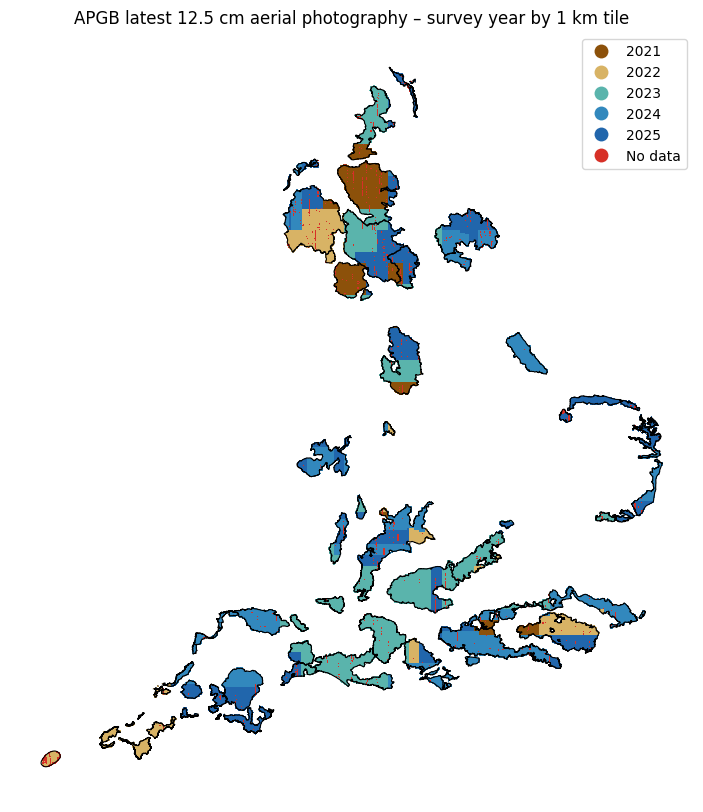

In [43]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10))

os_1k_pl.plot(
    column="year_cat",
    categorical=True,
    cmap=cmap,
    legend=True,
    ax=ax,
    linewidth=0,
)

pl.to_crs(27700).boundary.plot(
    ax=ax,
    color="black",
    linewidth=0.8
)

ax.set_axis_off()
ax.set_title("APGB latest 12.5 cm aerial photography – survey year by 1 km tile")
plt.show()

In [20]:
pl_latest.to_csv("pl_latest_apgb_12p5cm.csv", index=False)
pl_out.to_file("pl_latest_apgb_12p5cm.gpkg", layer="pl_latest", driver="GPKG")


In [21]:
pl.columns


Index(['CODE', 'NAME', 'MEASURE', 'DESIG_DATE', 'HOTLINK', 'STATUS',
       'geometry', 'STAT_AREA', 'GlobalID'],
      dtype='object')